In [24]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Autoencoders
https://avandekleut.github.io/vae/

In [15]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784,512)  # 28x28 pixel image
        self.relu1 = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(512, latent_dims)
        
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        return x

In [16]:
enc = Encoder(5)
enc

Encoder(
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=512, out_features=5, bias=True)
)

In [17]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims,512)
        self.relu1 = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(512, 784)
        self.sigmoid1 = nn.Sigmoid()

    def forward(self, z):
        z = self.linear1(z)
        z = self.relu1(z)
        z = self.linear2(z)
        z = self.sigmoid1(z)
        return z.reshape((-1,1,28,28))

In [18]:
dec = Decoder(5)
dec

Decoder(
  (linear1): Linear(in_features=5, out_features=512, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=512, out_features=784, bias=True)
  (sigmoid1): Sigmoid()
)

In [19]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
        
    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x

In [20]:
ae = Autoencoder(5)
ae

Autoencoder(
  (encoder): Encoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (relu1): ReLU(inplace=True)
    (linear2): Linear(in_features=512, out_features=5, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=5, out_features=512, bias=True)
    (relu1): ReLU(inplace=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
    (sigmoid1): Sigmoid()
  )
)

In [21]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [22]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=False),
        batch_size=128,
        shuffle=True)


In [23]:
autoencoder = train(autoencoder, data)

In [25]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

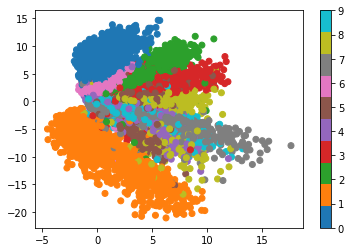

In [26]:
plot_latent(autoencoder, data)

In [27]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

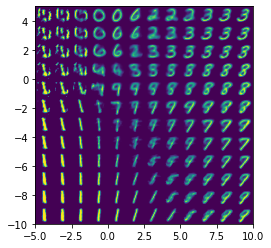

In [28]:
plot_reconstructed(autoencoder)

## Variational Autoencoders

In [36]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784,512)
        self.relu1 = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)
        
        self.N = torch.distributions.Normal(0,1)
#         self.N.loc = self.N.loc.cuda()  # move sampling to GPU
#         self.N.scale = self.N.scale.cuda() # same
        self.kl = 0
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = self.relu1(x)
        
        mu = self.linear2(x)
        log_sigma = self.linear3(x)
        sigma = torch.exp(log_sigma)
        
        z = mu + sigma * self.N.sample(mu.shape)
        
        # update KL divergence of N(mu,sigma) from N(0,1)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [37]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
        
    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x

In [38]:
vae = VariationalAutoencoder(5)
vae

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (relu1): ReLU(inplace=True)
    (linear2): Linear(in_features=512, out_features=5, bias=True)
    (linear3): Linear(in_features=512, out_features=5, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=5, out_features=512, bias=True)
    (relu1): ReLU(inplace=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
    (sigmoid1): Sigmoid()
  )
)

In [39]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [40]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data)

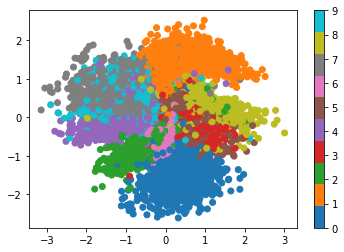

In [41]:
plot_latent(vae, data)

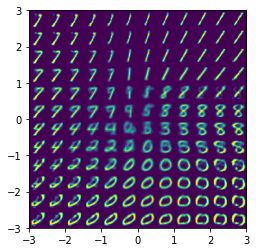

In [42]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

## VAE source 2
https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed

In [43]:
def kl_divergence(self, z, mu, std):
    # --------------------------
    # Monte carlo KL divergence
    # --------------------------
    # 1. define the first two probabilities (in this case Normal for both)
    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    q = torch.distributions.Normal(mu, std)

    # 2. get the probabilities from the equation
    log_qzx = q.log_prob(z)
    log_pz = p.log_prob(z)

    # kl
    kl = (log_qzx - log_pz)
    kl = kl.sum(-1)
    return kl

In [44]:
def gaussian_likelihood(self, x_hat, logscale, x):
    scale = torch.exp(logscale)
    mean = x_hat
    dist = torch.distributions.Normal(mean, scale)

    # measure prob of seeing image under p(x|z)
    log_pxz = dist.log_prob(x)
    return log_pxz.sum(dim=(1, 2, 3))

In [45]:
class VAE(nn.Module):
    def __init__(self, enc_out_dim, latent_dim):
        super(VAE, self).__init__()
        
        # self.encoder
        # self.decoder
    
        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)
        
        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
        
    def training_step(self, batch, batch_idx):
        x, _ = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(),
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

### VAE from paper
Design of metalloproteins and
novel protein folds using variational
autoencoders

https://github.com/psipred/protein-vae/blob/master/fold_gen/grammar_VAE_pytorch.py

In [55]:
class LB(nn.Module):
    def __init__(self, enc_in_dim, latent_dim):
        super(LB, self).__init__()
        
        self.linear=nn.Linear(enc_in_dim, latent_dim)
        self.bn = nn.BatchNorm1d(latent_dim)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(x):
        x = self.linear(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [56]:
lb = LB(512,42)
lb

LB(
  (linear): Linear(in_features=512, out_features=42, bias=True)
  (bn): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

In [57]:
class MLP(nn.Module):
    def __init__(self, sizes):
        super(MLP, self).__init__()
        
        self.block1 = LB(sizes[0],sizes[1])
        self.block2 = LB(sizes[1],sizes[2])
        self.block3 = LB(sizes[2],sizes[3])
        
    def forward(x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return x

In [58]:
mlp = MLP(sizes=[512, 256, 128, 16])
mlp

MLP(
  (block1): LB(
    (linear): Linear(in_features=512, out_features=256, bias=True)
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (block2): LB(
    (linear): Linear(in_features=256, out_features=128, bias=True)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (block3): LB(
    (linear): Linear(in_features=128, out_features=16, bias=True)
    (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
)

In [59]:
class Decoder2(nn.Module):
    def __init__(self, sizes):
        super(Decoder2, self).__init__()
        
        self.mlp = MLP(sizes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(x):
        x = self.mlp(x)
        x = self.sigmoid(x)
        return x

In [64]:
dec2 = Decoder2(sizes=[128,256,512, 1024])
dec2

Decoder2(
  (mlp): MLP(
    (block1): LB(
      (linear): Linear(in_features=128, out_features=256, bias=True)
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (block2): LB(
      (linear): Linear(in_features=256, out_features=512, bias=True)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (block3): LB(
      (linear): Linear(in_features=512, out_features=1024, bias=True)
      (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (sigmoid): Sigmoid()
)

In [68]:
class Encoder2(nn.Module):
    def __init__(self, sizes, latent_dim,beta):
        super(Encoder2, self).__init__()
        
        self.mlp = MLP(sizes)
        self.linear1 = nn.Linear(sizes[-1],latent_dim)
        self.linear2 = nn.Linear(sizes[-1], latent_dim)
        self.softplus = nn.Softplus(beta=beta)
        
    def forward(x):
        
        x = self.mlp(x)
        mu = self.linear1(x)
        sigma_squared = self.softplus(self.linear2(x))
        
        return mu, sigma_squared

In [69]:
enc2 = Encoder2([1024,512,256,128], 16,1.0)
enc2

Encoder2(
  (mlp): MLP(
    (block1): LB(
      (linear): Linear(in_features=1024, out_features=512, bias=True)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (block2): LB(
      (linear): Linear(in_features=512, out_features=256, bias=True)
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (block3): LB(
      (linear): Linear(in_features=256, out_features=128, bias=True)
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (linear1): Linear(in_features=128, out_features=16, bias=True)
  (linear2): Linear(in_features=128, out_features=16, bias=True)
  (softplus): Softplus(beta=1.0, threshold=20)
)